# Pixel-wise distance

Everything in grayscale

In [1]:
import numpy as np

In [2]:
def distance(p1, p2, coeff = 2):
    diff = ((p1 - p2) ** 2) ** 0.7
    return np.minimum(diff * coeff, np.ones(p1.shape) * 255)

# Denoising

In [3]:
from scipy import signal
def little_blur(img):
    kernel = np.ones((3, 3)) / 9.
    return signal.convolve2d(img, kernel)

In [4]:
from scipy import ndimage
def median(img, size=5):
    return ndimage.median_filter(img, size)

# Estimation

In [10]:
from PIL import Image

In [11]:
clear_path = '../data/test/000/000_0.png'
dirty_path = '../data/test/000/001_0.png'
mask_path  = '../data/test/mask/000/001_0.png'
mask_opacity = 80

# load images
clear = Image.open(clear_path)
dirty = Image.open(dirty_path)
# prepare them
clear = np.asarray(clear.convert('L'))
dirty = np.asarray(dirty.convert('L'))
# Little blur to denoise
clear = little_blur(clear)
dirty = little_blur(dirty)

In [12]:
diff = distance(clear, dirty)

In [13]:
# Post filtration
diff = median(diff)
diff = diff[1:-1, 1:-1]

In [14]:
# Select partition
mask = np.where(diff > 40, mask_opacity, 0)

# Hull correction

In [15]:
from queue import Queue
def find_component(matrix, start, used):
    h, w = matrix.shape
    result = []
    v = matrix[start]

    queue = Queue()
    queue.put(start)
    used[start] = True

    while not queue.empty():
        x, y = queue.get()
        result.append((x, y))
        for dx in range(max(x-1, 0), min(x+2, h)):
            for dy in range(max(y-1, 0), min(y+2, w)):
                if matrix[dx, dy] == v and not used[dx, dy]:
                    queue.put((dx, dy))
                    used[dx, dy] = True
    return result

In [16]:
from scipy.spatial import ConvexHull
from scipy.spatial import QhullError

In [17]:
from scipy.spatial import Delaunay
def in_hull(points, hull_points):
    hull = Delaunay(hull_points)
    return hull.find_simplex(points)>=0

In [18]:
def fill_hulls_entire(mask, points):
    points = np.asarray(points)
    mn = np.min(points, axis=0)
    mx = np.max(points, axis=0)
    rect = np.asarray([(x, y)
              for x in range(mn[0], mx[0])
              for y in range(mn[1], mx[1])
              ])

    if len(points) > 2:
        try:
            verts = ConvexHull(points).vertices
            hull = points[verts]
            is_in_hull = np.asarray(in_hull(rect, hull))
            in_hull_points = rect[np.where(is_in_hull)]
            for x, y in in_hull_points:
                mask[x, y] = mask_opacity
        except QhullError:
            print("Hull is empty. OK")

In [19]:
def fill_by_hull(mask):
    used = np.zeros(mask.shape, dtype=np.bool_)
    drops = []
    for (i, j), m in np.ndenumerate(mask):
        if m == mask_opacity and not used[i, j]:
            drops.append(find_component(mask, (i, j), used))
    for drop in drops:
        fill_hulls_entire(mask, drop)

In [20]:
fill_by_hull(mask)

Hull is empty. OK


# Visualization

In [21]:
from matplotlib import pyplot as plt

(-0.5, 623.5, 335.5, -0.5)

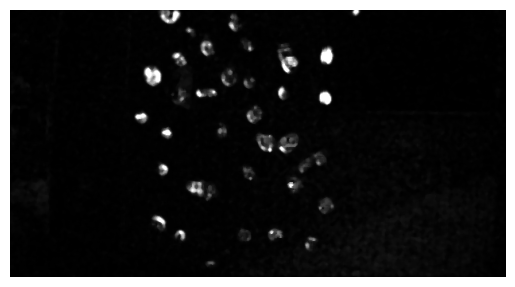

In [22]:
plt.imshow(diff, cmap="gray")
plt.axis('off')

(-0.5, 623.5, 335.5, -0.5)

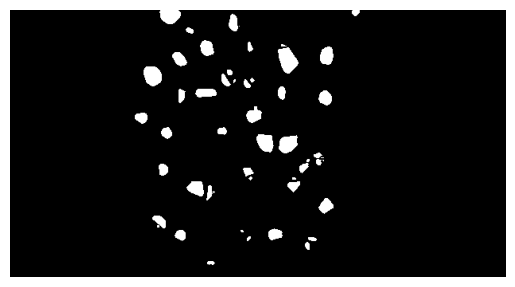

In [23]:
plt.imshow(mask, cmap="gray")
plt.axis('off')

In [24]:
def masked_image(background, mask):
    foreground = np.zeros((background.height, background.width, 4))
    foreground[:, :, 0].fill(255)
    foreground[:, :, 3] = mask
    print(foreground[0][0])
    foreground = Image.fromarray(foreground.astype('uint8'), "RGBA")

    background.paste(Image.new('RGB', background.size, (255, 0, 0)), mask=foreground)
    return background

In [25]:
masked = masked_image(Image.open(dirty_path), mask)

[255.   0.   0.   0.]


In [ ]:
from pathlib import Path
Path(mask_path).parent.mkdir(parents=True, exist_ok=True)

In [26]:
masked.save(mask_path)

(-0.5, 623.5, 335.5, -0.5)

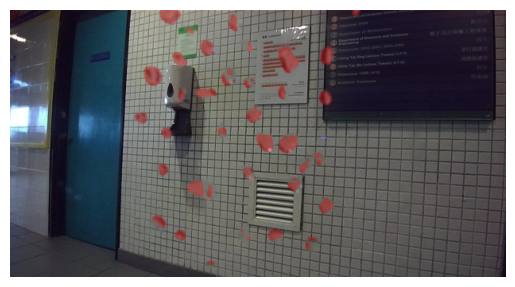

In [27]:
plt.imshow(masked, cmap="gray")
plt.axis('off')